In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = np.load("fmri_preprocessed_2017_09_18.npy")

data.shape

(16485, 300)

In [4]:
data = np.load("fmri_preprocessed_2017_09_18.npy")
data = np.transpose(data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = np.transpose(data)
data = np.expand_dims(data, axis=2)

random = np.random.permutation(np.shape(data)[0])
ratio = .70
number = int(ratio * np.shape(random)[0])
print(number)
training = data[0:number,:,:]
test = data[number:,:,:]


print('Training data shape:', np.shape(training))
print('Testing data shape:', np.shape(test))


11539
Training data shape: (11539, 300, 1)
Testing data shape: (4946, 300, 1)


/home/chris/projects/pig/env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
def m2():
    from keras.models import Sequential
    from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
    from keras import regularizers
    
    filters = [128, 64, 32]
    kernel_size = [40, 10, 5]
    pool_size = [2, 2, 3]
    upsample_size = [4,3,2]
    weight_decay = 0.00001
    
    model = Sequential()
        ### Encoding portion
    model.add(Conv1D(filters[0],
                         kernel_size[0],
                         input_shape=(300,1),
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[0], padding='same'))

    model.add(Conv1D(filters[1],
                         kernel_size[1],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[1], padding='same'))

    model.add(Conv1D(filters[2],
                         kernel_size[2],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[2], padding='same'))



    ### Decoding portion
    model.add(Conv1D(filters[1],
                         kernel_size[1],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[1]))


    model.add(Conv1D(filters[0],
                         kernel_size[0],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[0]))


        # Decoded output
    model.add(Conv1D(1, 1, activation='linear', padding='same'))

    #sgd = optimizers.SGD(lr=0.001, clipvalue=0.5, momentum=.9, decay=0.0001)
    model.compile(optimizer='Adadelta', loss='mse')
   
    
    return model

auto_model = m2()
auto_model.fit(training, training, batch_size=128, epochs=25, verbose=1, shuffle=True, validation_data=(test,test))


Train on 11539 samples, validate on 4946 samples
Epoch 1/25
11539/11539 [==============================] - 3s - loss: 0.9998 - val_loss: 0.9959
Epoch 2/25
11539/11539 [==============================] - 1s - loss: 0.8872 - val_loss: 0.7660
Epoch 3/25
11539/11539 [==============================] - 1s - loss: 0.7953 - val_loss: 0.7235
Epoch 4/25
11539/11539 [==============================] - 1s - loss: 0.7655 - val_loss: 0.7305
Epoch 5/25
11539/11539 [==============================] - 1s - loss: 0.7535 - val_loss: 0.7065
Epoch 6/25
11539/11539 [==============================] - 1s - loss: 0.7450 - val_loss: 0.7093
Epoch 7/25
11539/11539 [==============================] - 1s - loss: 0.7369 - val_loss: 0.6921
Epoch 8/25
11539/11539 [==============================] - 1s - loss: 0.7286 - val_loss: 0.6807
Epoch 9/25
11539/11539 [==============================] - 1s - loss: 0.7203 - val_loss: 0.6731
Epoch 10/25
11539/11539 [==============================] - 1s - loss: 0.7148 - val_loss: 0.6719


In [19]:
auto_model.save('full_pig_brandon.h5')

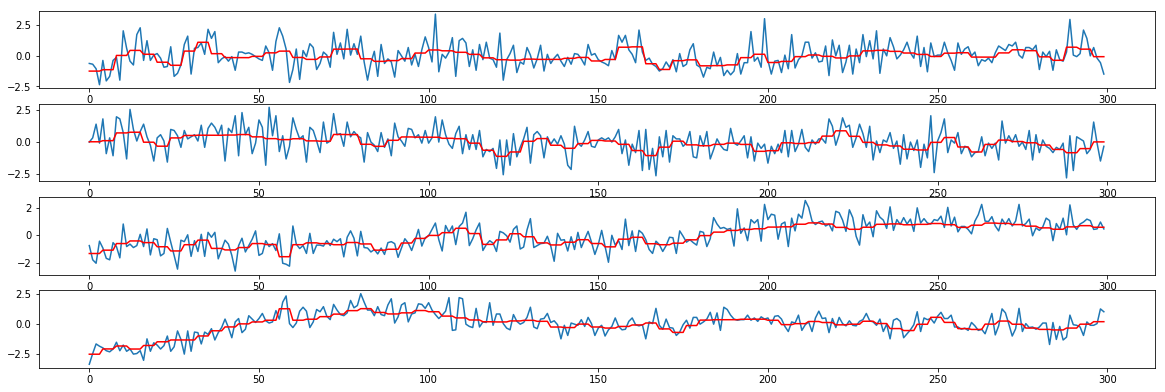

In [7]:
sample_1 = training[np.newaxis, 1000]
output_1 = auto_model.predict(sample_1)

sample_2 = training[np.newaxis, 10]
output_2 = auto_model.predict(sample_2)

sample_3 = training[np.newaxis, 66]
output_3 = auto_model.predict(sample_3)

sample_4 = training[np.newaxis, 587]
output_4 = auto_model.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')

In [15]:
auto_model.layers[6].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dilation_rate': (1,),
 'filters': 64,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': {'class_name': 'L1L2',
  'config': {'l1': 0.0, 'l2': 9.999999747378752e-06}},
 'kernel_size': (10,),
 'name': 'conv1d_10',
 'padding': 'same',
 'strides': (1,),
 'trainable': True,
 'use_bias': True}

In [17]:
embedding_model = keras.models.Model(inputs=auto_model.input,
                                 outputs=auto_model.layers[6].output)
embeddings = embedding_model.predict(data)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

In [18]:
print(embeddings.shape)
print(squished_embeddings.shape)

np.save('e12-embeddings-squished.npy', squished_embeddings)

(16485, 25, 64)
(16485, 1600)
